<a href="https://colab.research.google.com/github/crisdavid3335/Challenge-MLEngineer/blob/main/Machine_Learning_Engineer_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.exposure import equalize_hist
from scipy.ndimage import gaussian_filter
import random


# tf.keras.preprocessing.image.ImageDataGenerato # No se si cuente como api,
# pero creo que puedo hacer una similar

# setting seed for reproducibility
SEED = 34
np.random.seed(SEED)
PATH_DOGS = '/content/drive/MyDrive/PENTO_IMGS/dogs'
TARGET_SIZE = 224
BATCH_SIZE = 64


def load_names_images(directory: str) -> dict:
    return {
        breed: [
            file for file in os.listdir(os.path.join(directory, breed))
            if file.lower().endswith(('jpg', 'jpeg', 'png'))
        ]
        for breed in [r for r in os.listdir(directory) if os.path.isdir(os.path.join(directory, r))]
    }


def load_images(data: dict) -> dict:
    return {
        breed: [
            (image.astype('uint8') if image.dtype != np.uint8 else image)
            for image in [
                plt.imread(os.path.join(PATH_DOGS, breed, name))
                for name in tqdm(data[breed], desc=f"Loading images from {breed}", leave=True)
            ]
        ]
        for breed in data
    }


def evaluate_shapes(images) -> None:
  for key in images:
    image_sizes = [img.shape for img in images[key]]
      # Check if all images have the same size
    if len(set(image_sizes)) == 1:
      print(f"All images have the same size: {image_sizes[0]}")
    else:
      print('\n', key, '='*100)
      print(f"Images have varying sizes. Here are some examples: {image_sizes[:5]}")


def resize_images(image_array, target_size):
    resized_images = []
    for img in image_array:
        pil_img = Image.fromarray(img)
        pil_img = pil_img.resize(target_size, Image.LANCZOS)
        resized_images.append(np.array(pil_img))
    return np.array(resized_images)


def plot_image(images, labels):
    # select 16 random images
    random_indices = np.random.choice(len(images), size=16, replace=False)
    random_images = np.array(images)[random_indices]
    random_labels = np.array(labels)[random_indices]

    # plot the 16 random images, with their labels
    fig, axes = plt.subplots(4, 4, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], cmap="gray")

        ax.set_title(random_labels[i], fontsize=5)
        ax.axis("off")
    plt.tight_layout()

    plt.show()


def basic_stats(images, range=(0, 256)):
    # Flatten the array to 1D for histogram and statistics
    pixels = images.flatten()

    # Generate histogram
    plt.hist(pixels, bins=256, range=range, color="gray")
    plt.title("Pixel Value Distribution")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate and print basic statistics
    mean_value = np.mean(pixels)
    median_value = np.median(pixels)
    std_dev = np.std(pixels)

    print(f"Mean pixel value: {mean_value}")
    print(f"Median pixel value: {median_value}")
    print(f"Standard Deviation of pixel values: {std_dev}")


In [2]:
names = load_names_images(PATH_DOGS)
images = load_images(names)


evaluate_shapes(images)

for k in tqdm(images, desc="Image resizing"):
  images[k] = resize_images(images[k], (TARGET_SIZE, TARGET_SIZE))

evaluate_shapes(images)

all_labels = []
all_images = []
for k in images:
  all_images.extend([v for v in images[k]])
  all_labels.extend([k for v in images[k]])

Loading images from german_shepherd:   0%|          | 0/20 [00:00<?, ?it/s]

Loading images from poodle:   0%|          | 0/20 [00:00<?, ?it/s]

Loading images from golden_retriever:   0%|          | 0/20 [00:00<?, ?it/s]

Loading images from french_bulldog:   0%|          | 0/20 [00:00<?, ?it/s]


 german_shepherd ====================================================================================================
Images have varying sizes. Here are some examples: [(1200, 1920, 3), (1314, 1125, 3), (1412, 1060, 3), (880, 1200, 3), (3008, 2000, 3)]

 poodle ====================================================================================================
Images have varying sizes. Here are some examples: [(1696, 1875, 3), (1500, 1125, 3), (1500, 1500, 3), (1921, 1661, 3), (1879, 2280, 3)]

 golden_retriever ====================================================================================================
Images have varying sizes. Here are some examples: [(1500, 1125, 3), (1200, 1600, 3), (874, 1197, 3), (1194, 1242, 3), (1500, 1125, 3)]

 french_bulldog ====================================================================================================
Images have varying sizes. Here are some examples: [(953, 1027, 3), (1500, 1125, 3), (1500, 1347, 3), (3120, 2956, 3), (1396

Image resizing:   0%|          | 0/4 [00:00<?, ?it/s]

All images have the same size: (224, 224, 3)
All images have the same size: (224, 224, 3)
All images have the same size: (224, 224, 3)
All images have the same size: (224, 224, 3)


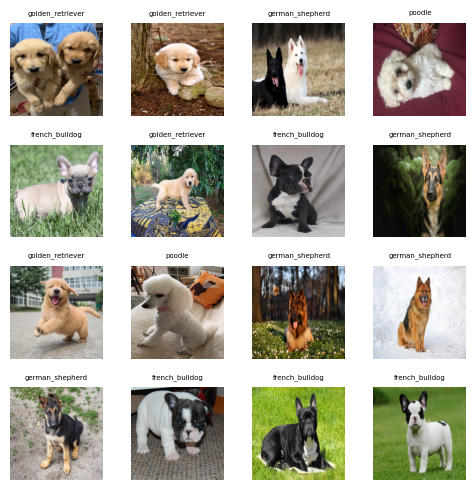

In [3]:
# print some images
plot_image(all_images, all_labels)

In [4]:

def _rotation(image_array, angle):
    input_dtype = image_array.dtype
    is_float = np.issubdtype(input_dtype, np.floating)

    if is_float:
        image_array_uint8 = (image_array * 255).clip(0, 255).astype(np.uint8)
    else:
        image_array_uint8 = image_array

    image = Image.fromarray(image_array_uint8)
    rotated = image.rotate(angle, resample=Image.BICUBIC, expand=True)
    r_array = np.array(rotated)
    mask = np.all(r_array == 0, axis=-1)
    edge_color = np.mean(r_array[~mask][:100], axis=0)
    distance = np.zeros_like(mask, dtype=float)
    distance[mask] = 1
    distance = gaussian_filter(distance, sigma=2)

    for i in range(3):
        channel = r_array[:,:,i].astype(float)
        channel[mask] = edge_color[i]
        blurred = gaussian_filter(channel, sigma=1)
        r_array[:,:,i] = np.clip(channel * (1 - distance) + blurred * distance, 0, 255).astype(np.uint8)

    if is_float:
        return r_array.astype(np.float32) / 255.0
    else:
        return r_array.astype(input_dtype)

def _zoom_image(image_array: np.ndarray, scale: float) -> np.ndarray:
  'esta fue dificil'
  input_dtype = image_array.dtype
  is_float = np.issubdtype(input_dtype, np.floating)

  if is_float:
    image_array_uint8 = (image_array * 255).clip(0, 255).astype(np.uint8)
  else:
    image_array_uint8 = image_array

  zoomed = np.array(
    Image.fromarray(image_array_uint8)
    .resize((int(image_array.shape[1] * scale), int(image_array.shape[0] * scale)), Image.BICUBIC)
    .crop(((int(image_array.shape[1] * scale) - image_array.shape[1]) // 2,
        (int(image_array.shape[0] * scale) - image_array.shape[0]) // 2,
        (int(image_array.shape[1] * scale) + image_array.shape[1]) // 2,
        (int(image_array.shape[0] * scale) + image_array.shape[0]) // 2))
  )

  if is_float:
    return zoomed.astype(np.float32) / 255.0
  else:
    return zoomed.astype(input_dtype)

def _horizontal_flip(image_array: np.ndarray) -> np.ndarray:
    return np.fliplr(image_array)

def create_alternative_data(images: list, labels: list, num_of_copys: int) -> tuple[list, list]:
    new_data = []
    new_labels = []

    for i in tqdm(range(num_of_copys), desc='Generando data', colour='red', unit='copys'):
      for image, target in zip(images, labels):
        new_labels.append(target)
        # Data augmentation
        zoomed = _zoom_image(image, np.max([random.random(), 0.8]))
        rotated = _rotation(zoomed, random.randint(0, 360))
        if np.random.random() > 0.5:
          flipped = _horizontal_flip(rotated)
        else:
          flipped = rotated

        if np.issubdtype(image.dtype, np.floating):
            flipped = np.array(Image.fromarray((flipped * 255).astype(np.uint8)).resize((224, 224))).astype(np.float32) / 255.0
        else:
            flipped = np.array(Image.fromarray(flipped.astype(np.uint8)).resize((224, 224))).astype(image.dtype)

        new_data.append(flipped)
    return images + new_data, labels + new_labels

# Applying the generator to the all data
all_images, all_labels = create_alternative_data(all_images, all_labels, 2*16)

Generando data:   0%|          | 0/32 [00:00<?, ?copys/s]

In [5]:
len(all_images)

2640

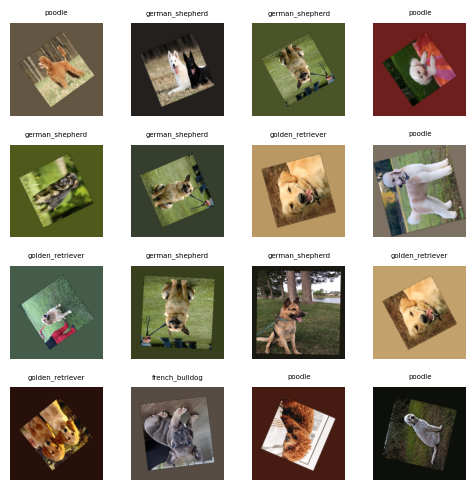

In [9]:
# Data augmentation
plot_image(all_images, all_labels)